## Amortized SVGD for toy distributions

Author: Chunyuan Li ( http://chunyuan.li/ ). 
Tensorflow implementation of SVGD algorithm.

Please contact me if there is any issue.

Reference: Stein Variational Gradient Descent (SVGD): A General Purpose Bayesian Inference Algorithm, NIPS2017

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pdb
import matplotlib
# import some stuff
from __future__ import division, print_function

from scipy.stats import gaussian_kde

import os
import pandas as pd
import seaborn as sns

# set gpu device - only important for multi gpu systems
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf

rng = np.random.RandomState()
np.random.seed(44)

/home/kd/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Test toy distributions:

The SVGD update rule:

In [4]:
def svgd_kernel(X0):
    XY = tf.matmul(X0, tf.transpose(X0))
    X2_ = tf.reduce_sum(tf.square(X0), axis=1)

    x2 = tf.reshape( X2_, shape=( tf.shape(X0)[0], 1) )
    
    X2e = tf.tile(x2, [1, tf.shape(X0)[0] ] )
    H = tf.subtract(tf.add(X2e, tf.transpose(X2e) ), 2 * XY)

    V = tf.reshape(H, [-1,1]) 

    # median distance
    def get_median(v):
        v = tf.reshape(v, [-1])
        m = v.get_shape()[0]//2
        return tf.nn.top_k(v, m).values[m-1]
    h = get_median(V)
    h = tf.sqrt(0.5 * h / tf.log( tf.cast( tf.shape(X0)[0] , tf.float32) + 1.0))

    # compute the rbf kernel
    Kxy = tf.exp(-H / h ** 2 / 2.0)

    dxkxy = -tf.matmul(Kxy, X0)
    sumkxy = tf.expand_dims(tf.reduce_sum(Kxy, axis=1), 1) 
    dxkxy = tf.add(dxkxy, tf.multiply(X0, sumkxy)) / (h ** 2)

    return (Kxy, dxkxy)

In [5]:
'''
    This is svgd version for 3d tensor X0
    The first dimension is number of images,
    second is number of z per images,
    third dimension is the dimension of z
'''

def svgd_kernel_tensor(X0):

    XY = tf.matmul(X0, tf.transpose(X0, perm=[0, 2, 1]) )
    x2 = tf.reshape(tf.reduce_sum(tf.square(X0),axis=2), ( tf.shape(X0)[0], tf.shape(X0)[1], 1))
    X2e = tf.tile(x2, [1,1,tf.shape(X0)[1]] )
    H = tf.subtract(tf.add(X2e, tf.transpose(X2e, perm=[0,2,1] )), 2 * XY)

    V = tf.reshape(H, [-1,1]) 
    # median distance
    def get_median(v):
        v = tf.reshape(v, [-1])
        m = v.get_shape()[0]//2
        return tf.nn.top_k(v, m).values[m-1]
    h = get_median(V)
    h = tf.sqrt(0.5 * h / tf.log( tf.cast( tf.shape(X0)[1] , tf.float32) + 1.0))

    Kxy = tf.exp(-H / tf.tile(  tf.ones([1,1,1])*h , (1, tf.shape(X0)[1], tf.shape(X0)[1])) ** 2 / 2.0)

    dxkxy = - tf.matmul(Kxy, X0)
    sumkxy = tf.expand_dims(tf.reduce_sum(Kxy, axis=2), 2) 
    dxkxy = tf.add(dxkxy, tf.multiply(X0, sumkxy)) / (tf.tile(  tf.ones([1,1,1])*h , (1, tf.shape(X0)[1], tf.shape(X0)[2])) ** 2)

    return (Kxy, dxkxy, h)

In [44]:
dtype = tf.float32
num_particles=128*4 
num_latent = 1
lr = 0.001
alpha=.9
fudge_factor = 1e-6
num_iter = 5000
range_limit = [-1,1]
npoints_plot=50

Text(0.5,1,u'Target distribution: $u(z)$')

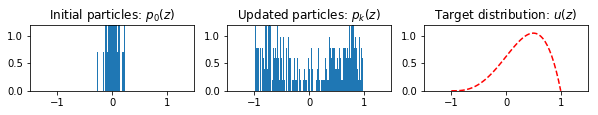

In [45]:
z  = tf.placeholder(tf.float32, [num_particles, num_latent])
prob = tf.maximum( (1- (z/2.0 + 0.5))**(0.5) * (z/2.0 + 0.5)**(5) + (1- (z/2.0 + 0.5))**(5) * (z/2.0 + 0.5)**(0.5), 1e-4 )
f = tf.log(prob)

log_p_grad = tf.squeeze(tf.gradients(f, z), axis=[0])
out = svgd_kernel(z) # call MAIN update
kernel_matrix, kernel_gradients = out[0], out[1]

grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles
z_np = -np.random.randn(num_particles, num_latent)*.1

fig, _ = plt.subplots(figsize=(10, 5))
ax=plt.subplot(1,3,1, aspect='equal')

plt.hist(z_np[:,0],200, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Initial particles: $p_0(z)$')

with tf.Session() as s:
    for i in xrange(num_iter):
        grad_theta_ = s.run( grad_theta, feed_dict={z: z_np } )
        z_np = z_np + lr * grad_theta_

ax=plt.subplot(1,3,2, aspect='equal')
plt.hist(z_np[:,0],200, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Updated particles: $p_k(z)$')

# plot the Target distribution
z_pp  = tf.placeholder(tf.float32, [None, num_latent])

ax=plt.subplot(1,3,3, aspect='equal')
from scipy.stats import beta 
coords = np.linspace(range_limit[0], range_limit[1], npoints_plot)
plt.plot(coords, 0.25*(beta.pdf(coords/2.0 + 0.5, 6, 1.5) + beta.pdf(coords/2.0 + 0.5, 1.5, 6)), 'r--')


plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Target distribution: $u(z)$')

In [46]:
np.save('samples_svgd_constrained_teacher_2mode.npy', z_np)

### Adversarial-based Amortized SVGD

In [37]:
slim = tf.contrib.slim
ds = tf.contrib.distributions

Instructions for updating:
Use the retry module or similar alternatives.


In [38]:
""" parameters """
input_dim = 1
latent_dim = 1
eps_dim = 1
batch_size = num_particles

n_layer_disc = 2
n_hidden_disc = 256
n_layer_gen = 2
n_hidden_gen= 256
n_layer_inf = 2
n_hidden_inf= 256

In [39]:
def linear(input, output_dim, scope='linear', stddev=0.01):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope):
        w = tf.get_variable('weights', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('biases', [output_dim], initializer=const)
        return tf.matmul(input, w) + b


def generative_network(z, input_dim, n_layer, n_hidden, eps_dim):
    with tf.variable_scope("generative"):
        Normal = tf.distributions.Normal(loc=tf.zeros(eps_dim), scale=tf.ones(eps_dim))
        eps = Normal.sample([batch_size])        
        h = tf.concat([z, eps], 1) 
        h = tf.nn.relu(linear(h, n_hidden_gen, 'g_hidden1'))
        h = tf.nn.relu(linear(h, n_hidden_gen, 'g_hidden2'))
        x = slim.fully_connected(h, input_dim, activation_fn=tf.nn.tanh, scope="p_x")
    return x


def inference_network(x, latent_dim, n_layer, n_hidden, eps_dim):
    with tf.variable_scope("inference"):
        Normal = tf.distributions.Normal(loc=tf.zeros(eps_dim), scale=tf.ones(eps_dim))
        eps = Normal.sample([batch_size]) * 0.0
        h = tf.concat([x, eps], 1) 
        h = tf.nn.relu(linear(h, n_hidden_inf, 'i_hidden1'))
        h = tf.nn.relu(linear(h, n_hidden_inf, 'i_hidden2'))        
        z = slim.fully_connected(h, latent_dim, activation_fn=None, scope="q_z")
    return z


def disc_network(x, n_layers=2, n_hidden=256, activation_fn=None, reuse=None):
    """Approximate x log data density."""
    h = x
    with tf.variable_scope('discriminator', reuse=reuse):
        h = tf.nn.relu(linear(h, n_hidden_disc, 'd_hidden1'))
        h = tf.nn.relu(linear(h, n_hidden_disc, 'd_hidden2'))           
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])


def disc_pair_network(x,z, n_layers=2, n_hidden=256, activation_fn=None, reuse=None):
    """Approximate (x,z) log data density."""
    h = tf.concat([x,z], 1)
    with tf.variable_scope('discriminator_pair', reuse=reuse):
        h = tf.nn.relu(linear(h, n_hidden_disc, 'd_hidden1'))
        h = tf.nn.relu(linear(h, n_hidden_disc, 'd_hidden2'))  
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])


Marginal distribution

In [78]:
""" Construct model and training ops """
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(batch_size, input_dim))
z = tf.placeholder(tf.float32, shape=(batch_size, latent_dim))

# decoder and encoder
p_x = generative_network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)

gen_logit = disc_network(p_x, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(gen_logit), logits=gen_logit)

obs_logit = disc_network(x, n_layers=n_layer_disc, n_hidden=n_hidden_disc, reuse=True)
obs_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(gen_logit), logits=obs_logit)

disc_loss = tf.reduce_mean(  gen_loss ) + tf.reduce_mean( obs_loss)

rec_z = inference_network(p_x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim )
cost_z = tf.reduce_mean(tf.pow(rec_z - z, 2))

gen_loss_x = tf.reduce_mean(  gen_logit ) 

gen_loss = 1.*gen_loss_x + 1.0*cost_z

qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

opt = tf.train.AdamOptimizer(1e-3, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars)

0
1
2
3
4
5
6
7
8
9


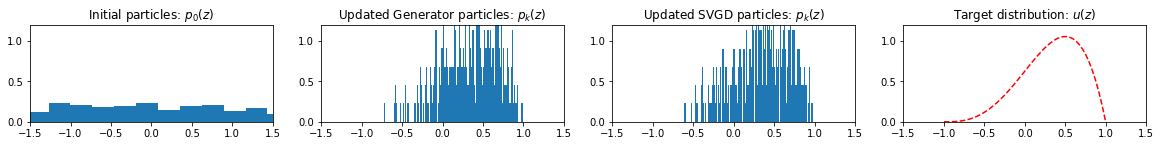

In [79]:
""" training """

x_target = tf.placeholder(tf.float32, [num_particles, num_latent])

prob =  tf.maximum( (1- (x_target/2.0 + 0.5) )*(x_target/2.0 + 0.5) **(3.0), 0.0 ) # tf.exp(f)
f = tf.log(prob)
log_p_grad = tf.squeeze(tf.gradients(f, x_target), axis=[0])


out = svgd_kernel(x_target) # call SVGD update
kernel_matrix, kernel_gradients = out[0], out[1]
grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles

# plot initial particle position
z_np = -np.random.randn(num_particles, num_latent)*2.0
fig, _ = plt.subplots(figsize=(20, 5))
ax=plt.subplot(1,4,1, aspect='equal')
plt.hist(z_np[:,0],50, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Initial particles: $p_0(z)$')

num_iter = 10
with tf.Session() as s:
    s.run(tf.global_variables_initializer())


    for i in range(num_iter):
        print(i)
        
        # generate current samples to update
        for _ in range(1):
            zmb = np.random.normal(size=(num_particles, 1))
            x_gen_np = s.run( p_x, feed_dict={z:zmb}) 

        # update target particle via SVGD
        x_target_np = x_gen_np
        for _ in range(500):
            grad_theta_ = s.run( grad_theta, feed_dict={x_target: x_target_np } )
            # print(grad_theta_)
            x_target_np = x_target_np + lr * grad_theta_
  
        for _ in range(200):            
            for _ in range(5):
                zmb = np.random.normal(size=(num_particles, 1))
                x_gen_np, f_g  = s.run([ p_x, train_gen_op], feed_dict={z:zmb})    

            # update discriminator
            for _ in range(1):
                f_d, _ = s.run([disc_loss, train_disc_op], feed_dict={x: x_target_np, z:zmb})    

    # plot generator's particle
    ax=plt.subplot(1,4,2, aspect='equal')
    plt.hist(x_gen_np[:,0],200, normed=1)  
    plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Updated Generator particles: $p_k(z)$')
  
    
    
    # plot SVGD's particle
    ax=plt.subplot(1,4,3, aspect='equal')
    plt.hist(x_target_np[:,0],200, normed=1)  
    plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Updated SVGD particles: $p_k(z)$')

    # plot the Target distribution
    ax=plt.subplot(1,4,4, aspect='equal')
    from scipy.stats import beta 
    coords = np.linspace(range_limit[0], range_limit[1], npoints_plot)
    plt.plot(coords, 0.25*(beta.pdf(coords/2.0 + 0.5, 6, 1.5) + beta.pdf(coords/2.0 + 0.5, 1.5, 6)), 'r--')


    plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Target distribution: $u(z)$')
    plt.show()
    
    # generate samples to visualize
    x_gen = []
    for _ in range(10):
        zmb = np.random.normal(size=(num_particles, 1))
        x_gen_np = s.run( p_x, feed_dict={z:zmb}) 
        x_gen.append(x_gen_np)
    x_gen = np.concatenate(x_gen, 0)
    
    np.savez('samples_svgd_constrained.npz', nn_samples=x_gen, svgd_samples=x_target_np)
    
    s.close()

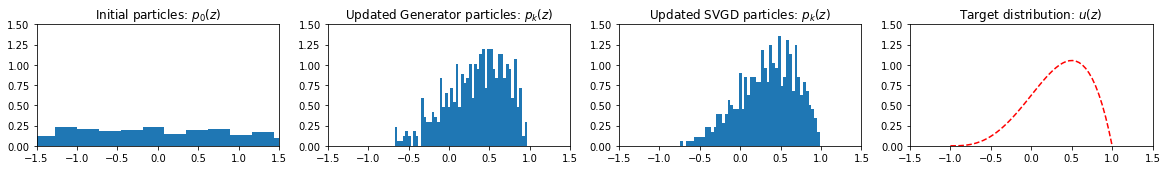

In [81]:


fig, _ = plt.subplots(figsize=(20, 5))
ax=plt.subplot(1,4,1, aspect='equal')
plt.hist(z_np[:,0],50, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.5]); ax.set_title('Initial particles: $p_0(z)$')


ax=plt.subplot(1,4,2, aspect='equal')
plt.hist(x_gen_np[:,0],50, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.5]); ax.set_title('Updated Generator particles: $p_k(z)$')

# plot SVGD's particle
ax=plt.subplot(1,4,3, aspect='equal')
plt.hist(x_target_np[:,0],50, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.5]); ax.set_title('Updated SVGD particles: $p_k(z)$')


# plot the Target distribution
ax=plt.subplot(1,4,4, aspect='equal')
from scipy.stats import beta 
coords = np.linspace(range_limit[0], range_limit[1], npoints_plot)
plt.plot(coords, 0.25*(beta.pdf(coords/2.0 + 0.5, 6, 1.5) + beta.pdf(coords/2.0 + 0.5, 1.5, 6)), 'r--')


plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.5]); ax.set_title('Target distribution: $u(z)$')
plt.show()
    

### L2 loss for amortized SGVD

In [50]:
""" Construct model and training ops """
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(batch_size, input_dim))
z = tf.placeholder(tf.float32, shape=(batch_size, latent_dim))

# generate particles and compute its distance to targets using l2 loss
p_x = generative_network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)
gen_loss =  tf.reduce_mean(tf.pow(p_x - x, 2))

pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")

opt = tf.train.AdamOptimizer(1e-3, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list=pvars)

0
1
2
3
4
5
6
7
8
9


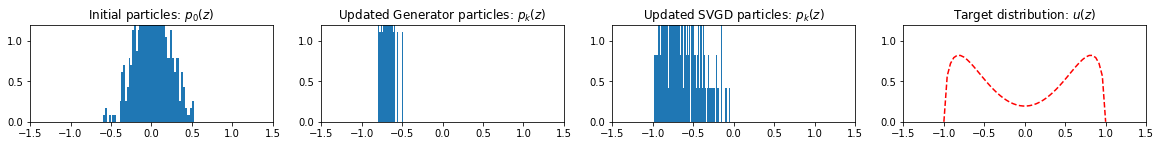

In [53]:
""" training """

x_target = tf.placeholder(tf.float32, [num_particles, num_latent])
prob = tf.maximum( (1- (x_target/2.0 + 0.5))**(0.5) * (x_target/2.0 + 0.5)**(5) + (1- (x_target/2.0 + 0.5))**(5) * (x_target/2.0 + 0.5)**(0.5), 0.0 )

f = tf.log(prob)
log_p_grad = tf.squeeze(tf.gradients(f, x_target), axis=[0])


out = svgd_kernel(x_target) # call SVGD update
kernel_matrix, kernel_gradients = out[0], out[1]
grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles

# plot initial particle position
z_np = -np.random.randn(num_particles, num_latent)*0.2
fig, _ = plt.subplots(figsize=(20, 5))
ax=plt.subplot(1,4,1, aspect='equal')
plt.hist(z_np[:,0],50, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Initial particles: $p_0(z)$')

num_iter = 10
with tf.Session() as s:
    s.run(tf.global_variables_initializer())


    for i in range(num_iter):
        print(i)
        
        # generate current samples to update
        for _ in range(1):
            zmb = np.random.normal(size=(num_particles, 1))
            x_gen_np = s.run( p_x, feed_dict={z:zmb}) 

        # update target particle via SVGD
        x_target_np = x_gen_np
        for _ in range(1000):
            grad_theta_ = s.run( grad_theta, feed_dict={x_target: x_target_np } )
            # print(grad_theta_)
            x_target_np = x_target_np + lr * grad_theta_
  
        zmb = np.random.normal(size=(num_particles, 1)) 
        for _ in range(1000):            
                x_gen_np, f_g  = s.run([ p_x, train_gen_op], feed_dict={z:zmb, x:x_target_np})    

    # plot generator's particle
    ax=plt.subplot(1,4,2, aspect='equal')
    plt.hist(x_gen_np[:,0],200, normed=1)  
    plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Updated Generator particles: $p_k(z)$')
  
    
    # plot SVGD's particle
    ax=plt.subplot(1,4,3, aspect='equal')
    plt.hist(x_target_np[:,0],200, normed=1)  
    plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Updated SVGD particles: $p_k(z)$')

    # plot the Target distribution
    ax=plt.subplot(1,4,4, aspect='equal')
    from scipy.stats import beta 
    coords = np.linspace(range_limit[0], range_limit[1], npoints_plot)
    plt.plot(coords, 0.25*(beta.pdf(coords/2.0 + 0.5, 6, 1.5) + beta.pdf(coords/2.0 + 0.5, 1.5, 6)), 'r--')

    plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Target distribution: $u(z)$')
    plt.show()
    
    # generate samples to visualize
    x_gen = []
    for _ in range(10):
        zmb = np.random.normal(size=(num_particles, 1))
        x_gen_np = s.run( p_x, feed_dict={z:zmb}) 
        x_gen.append(x_gen_np)
    x_gen = np.concatenate(x_gen, 0)
    
    np.savez('samples_svgd_constrained_L2_2mode.npz', nn_samples=x_gen, svgd_samples=x_target_np)
    
    s.close()

Text(0.5,1,u'Updated SVGD particles: $p_k(z)$')

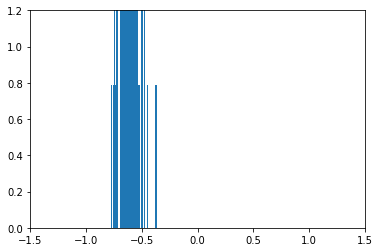

In [54]:
plt.hist(x_gen_np[:,0],200, normed=1)  
plt.xlim([-1.5,1.5]); plt.ylim([0.0, 1.2]); ax.set_title('Updated SVGD particles: $p_k(z)$')
